<a href="https://colab.research.google.com/github/misbahsy/APMonitor-do/blob/master/NonlinearControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nonlinear Model Predictive Control

<p class='vspace'>Dynamic control is also known as Nonlinear Model Predictive Control (NMPC) or simply as Nonlinear Control (NLC). NLC with predictive models is a dynamic optimization approach that seeks to follow a trajectory or drive certain values to maximum or minimum levels.
</p>
<div class='vspace'></div>

##Exercise

<p><strong>Objective:</strong> Design a controller to maintain temperature of a chemical reactor. Develop 3 separate controllers (PID, Linear MPC, Nonlinear MPC) in Python, MATLAB, or Simulink. Demonstrate controller performance with steps in the set point and disturbance changes. <em>Estimated time: 3 hours.</em>
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_control.zip' rel='nofollow'>CSTR Source Files</a> | <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_control.pdf' rel='nofollow'>Problem Information</a></div>
<div class='vspace'></div><div><img width='300px' src='http://apmonitor.com/do/uploads/Main/cstr.png' alt='' title='' /></div>
<p class='vspace'>A reactor is used to convert a hazardous chemical <strong>A</strong> to an acceptable chemical <strong>B</strong> in waste stream before entering a nearby lake. This particular reactor is dynamically modeled as a Continuously Stirred Tank Reactor (CSTR) with a simplified kinetic mechanism that describes the conversion of reactant <strong>A</strong> to product <strong>B</strong> with an irreversible and exothermic reaction. It is desired to maintain the temperature at a constant setpoint that maximizes the destruction of A (highest possible temperature). Adjust the jacket temperature (<em>T<sub>c</sub></em>) to maintain a desired  reactor temperature and minimize the concentration of <strong>A</strong>. The reactor temperature should never exceed 400 K. The cooling jacket temperature can be adjusted between 250 K and 350 K. 
</p>
<div class='vspace'></div><h4>Step Testing</h4>
<p>Step testing is required to obtain a process model for the PID controller and the linear model predictive controller. It is a first step in developing a controller. The following code implements either a doublet test or multiple steps to different levels. A doublet test starts with the system at steady state. Three moves of Manipulated Variable (MV) are made with sufficient time to nearly reach steady state conditions at two other operating points. The steps are above and below the nominal operating conditions. In this case, the cooling jacket temperature is raised, lowered, and brought back to 300 K (nominal operating condition.
</p>
<div class='vspace'></div><div><img width='550px' src='http://apmonitor.com/do/uploads/Main/cstr_doublet.png' alt='' title='' /></div>

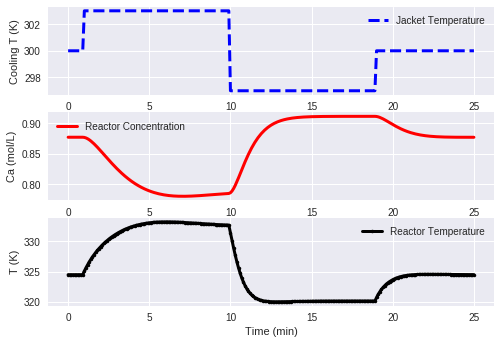

In [1]:
#@markdown Python Simulation Code

try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,25,251)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Step cooling temperature to 295
u[10:100] = 303.0
u[100:190] = 297.0
u[190:] = 300.0

# Simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('data_doublet.txt',data,delimiter=',',\
           header='Time,Tc,T',comments='')

# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,u,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'r-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'k.-',linewidth=3)
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(['Reactor Temperature'],loc='best')

plt.show()

<p class='vspace'>Additional steps are preferred for systems that show a high degree a nonlinearity or when there is little additional expense to obtain the data. The following code generates data at multiple input levels and with varying different step time intervals. The cooling jacket temperature is not raised above 305 K to avoid reactor instability in open loop.
</p>
<div class='vspace'></div><div><img width='550px' src='http://apmonitor.com/do/uploads/Main/cstr_step_tests.png' alt='' title='' /></div>

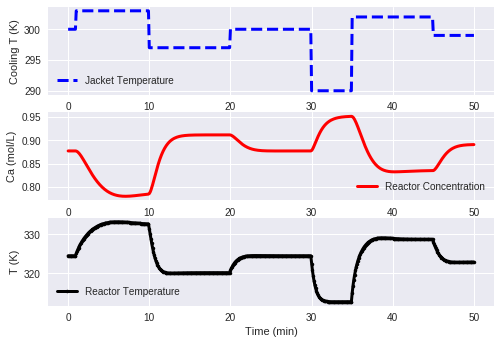

In [2]:
#@markdown Python Step Test Generator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define CSTR model
def cstr(x,t,Tc):
    Ca = x[0]
    T = x[1]
    Tf = 350
    Caf = 1.0
    q = 100
    V = 100
    rho = 1000
    Cp = 0.239
    mdelH = 5e4
    EoverR = 8750
    k0 = 7.2e10
    UA = 5e4
    rA = k0*np.exp(-EoverR/T)*Ca
    dCadt = q/V*(Caf - Ca) - rA
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
Tc_ss = 300.0

# Time Interval (min)
t = np.linspace(0,50,501)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tc = np.ones(len(t)) * Tc_ss

# Step cooling temperature
Tc[10:100]  = 303.0
Tc[100:200] = 297.0
Tc[200:300] = 300.0
Tc[300:350] = 290.0
Tc[350:400] = 302.0
Tc[400:450] = 302.0
Tc[450:]    = 299.0

# Simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(Tc[i+1],))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,Tc,T)) # vertical stack
data = data.T              # transpose data
np.savetxt('cstr_step_tests.txt',data,delimiter=',',\
           header='Time,Tc,T',comments='')

# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,Tc,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'r-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'k.-',linewidth=3)
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(['Reactor Temperature'],loc='best')

plt.show()

##Model Identification

<p>There are many methods to develop a controller model. For a PID controller, an <a class='urllink' href='https://apmonitor.com/pdc/index.php/Main/FirstOrderOptimization' rel='nofollow'>FOPDT model</a> is one method to obtain <a class='urllink' href='https://apmonitor.com/pdc/index.php/Main/ProportionalIntegralDerivative' rel='nofollow'>IMC tuning parameters</a>. For linear MPC, there are many options to obtain a controller model through <a class='wikilink' href='http://apmonitor.com/do/index.php/Main/ModelIdentification'>identification methods</a>. For nonlinear MPC, the nonlinear simulator equations can be used to develop the controller. This section demonstrates how to obtain a linear model for the MPC application using the step test data generated in the prior section.
</p>
<div class='vspace'></div><div><img width='550px' src='http://apmonitor.com/do/uploads/Main/cstr_arx_fit.png' alt='' title='' /></div>

   Time     Tc           T
0   0.0  300.0  324.475443
1   0.1  300.0  324.475443
2   0.2  300.0  324.475443
3   0.3  300.0  324.475443
4   0.4  300.0  324.475443
apm 35.230.39.168_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            6
   Variables    :         1512
   Intermediates:            0
   Connections  :            6
   Equations    :         1004
   Residuals    :         1004
 
 Number of state variables:            506
 Number of total equations: -          502
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              4
 
 **********************************************
 Model Parameter Estimation with Interior Point Solver
 *******

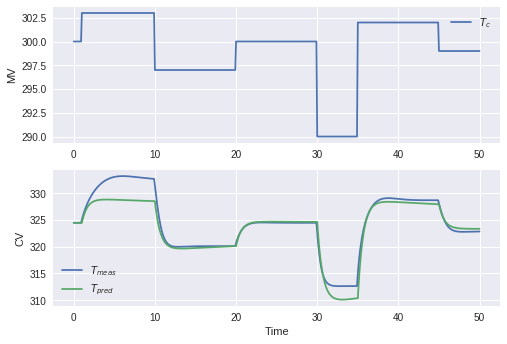

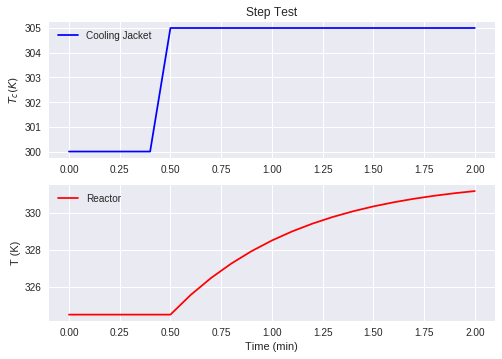

In [3]:
#@markdown Python ARX System ID

from gekko import GEKKO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# load data and parse into columns
url = 'http://apmonitor.com/do/uploads/Main/cstr_step_tests.txt'
data = pd.read_csv(url)
print(data.head())

# generate time-series model
t = data['Time']
u = data['Tc']
y = data['T']
m = GEKKO(remote=True) # remote=True for MacOS

# system identification
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,shift='init',scale=True,objf=100,diaglevel=1)

# plot results of fitting
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$T_c$'])
plt.ylabel('MV')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$T_{meas}$',r'$T_{pred}$'])
plt.ylabel('CV')
plt.xlabel('Time')
plt.savefig('sysid.png')

# step test model
yc,uc = m.arx(p)

# rename MV and CV
Tc = uc[0]
T = yc[0]

# steady state initialization
m.options.IMODE = 1
Tc.value = 300
m.solve(disp=False)

# dynamic simulation (step test validation)
m.time = np.linspace(0,2,21)
m.options.IMODE = 4
Tc.value = np.ones(21)*300
Tc.value[5:] = 305
m.solve(disp=False)

plt.figure()
plt.subplot(2,1,1)
plt.title('Step Test')
plt.plot(m.time,Tc.value,'b-',label='Cooling Jacket')
plt.ylabel(r'$T_c (K)$')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m.time,T.value,'r-',label='Reactor')
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend()

plt.show()

In [4]:
#@title ##Predictive Control
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ZvvQ0_PdMPk" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>


In [0]:
#@markdown GEKKO Linear First-Order MPC Code


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from gekko import GEKKO

# Steady State Initial Condition
u_ss = 280.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Steady State Initial Conditions for the States
Ca_ss = 1
T_ss = 304
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

#%% GEKKO linear MPC
m = GEKKO(remote=True)
m.time = [0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5]

# initial conditions
Tc0 = 280
T0 = 304
Ca0 = 1.0

tau = m.Const(value = 0.5)
Kp = m.Const(value = 1)

m.Tc = m.MV(value = Tc0,lb=250,ub=350)
m.T = m.CV(value = T_ss)

m.Equation(tau * m.T.dt() == -(m.T - T0) + Kp * (m.Tc - Tc0))

#MV tuning
m.Tc.STATUS = 1
m.Tc.FSTATUS = 0
m.Tc.DMAX = 100
m.Tc.DMAXHI = 5   # constrain movement up
m.Tc.DMAXLO = -100 # quick action down
#CV tuning
m.T.STATUS = 1
m.T.FSTATUS = 1
m.T.SP = 330
m.T.TR_INIT = 2
m.T.TAU = 1.0
m.options.CV_TYPE = 2
m.options.IMODE = 6
m.options.SOLVER = 3

#%% define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Time Interval (min)
t = np.linspace(0,10,501)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tsp = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Set point steps
Tsp[0:100] = 330.0
Tsp[100:200] = 350.0
Tsp[200:300] = 370.0
Tsp[300:] = 390.0

# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Simulate CSTR
for i in range(len(t)-1):
    # simulate one time period (0.05 sec each loop)
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i],Tf,Caf))
    # retrieve measurements
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    # insert measurement
    m.T.MEAS = T[i+1]
    # update setpoint
    m.T.SP = Tsp[i+1]
    # solve MPC
    m.solve(disp=True)
    # change to a fixed starting point for trajectory
    m.T.TR_INIT = 2
    # retrieve new Tc value
    u[i+1] = m.Tc.NEWVAL
    # update initial conditions
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

    #%% Plot the results
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(t[0:i],u[0:i],'b--',linewidth=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t[0:i],Ca[0:i],'r-',linewidth=3)
    plt.ylabel('Ca (mol/L)')
    plt.legend(['Reactor Concentration'],loc='best')

    plt.subplot(3,1,3)
    plt.plot(t[0:i],Tsp[0:i],'k-',linewidth=3,label=r'$T_{sp}$')
    plt.plot(t[0:i],T[0:i],'b.-',linewidth=3,label=r'$T_{meas}$')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.draw()
    plt.pause(0.01)

In [0]:
#@markdown GEKKO ARX MPC Code

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
from gekko import GEKKO

# load data and parse into columns
url = 'http://apmonitor.com/do/uploads/Main/cstr_step_tests.txt'
data = pd.read_csv(url)
print(data.head())

# generate time-series model
t = data['Time']
u = data['Tc']
y = data['T']
m = GEKKO(remote=True)

# system identification
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,shift='init',scale=True,objf=100,diaglevel=1)

# plot results of fitting
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$T_c$'])
plt.ylabel('MV')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$T_{meas}$',r'$T_{pred}$'])
plt.ylabel('CV')
plt.xlabel('Time')
plt.savefig('sysid.png')
plt.show()

# step test model
yc,uc = m.arx(p)

# rename MV and CV
m.Tc = uc[0]
m.T = yc[0]

# steady state initialization
m.options.IMODE = 1
m.Tc.value = 280
m.solve(disp=True)

# GEKKO linear MPC
m.time = np.linspace(0,2,21)

# MV tuning
m.Tc.STATUS = 1
m.Tc.FSTATUS = 0
m.Tc.DMAX = 100
m.Tc.DCOST = 0.1
m.Tc.DMAXHI = 5   # constrain movement up
m.Tc.DMAXLO = -100 # quick action down
m.Tc.UPPER = 350
m.Tc.LOWER = 250
# CV tuning
m.T.STATUS = 1
m.T.FSTATUS = 1
m.T.SP = 330
m.T.TR_INIT = 1
m.T.TAU = 1.2
m.options.CV_TYPE = 2
m.options.IMODE = 6
m.options.SOLVER = 3

# define CSTR (plant)
def cstr(x,t,Tc):
    Ca,T = x
    Tf = 350; Caf = 1.0; q = 100; V = 100
    rho = 1000; Cp = 0.239; mdelH = 5e4
    EoverR = 8750; k0 = 7.2e10; UA = 5e4
    rA = k0*np.exp(-EoverR/T)*Ca
    dCadt = q/V*(Caf - Ca) - rA
    dTdt = q/V*(Tf - T) + mdelH/(rho*Cp)*rA + UA/V/rho/Cp*(Tc-T)
    return [dCadt,dTdt]

# Time Interval (min)
t = np.linspace(0,20,201)

# Store results for plotting
Ca_ss = 1; T_ss = 304; Tc_ss = 280
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tsp = np.ones(len(t)) * T_ss
Tc = np.ones(len(t)) * Tc_ss

# Set point steps
Tsp[0:40] = 330.0
Tsp[40:80] = 350.0
Tsp[80:120] = 370.0
Tsp[120:] = 390.0

# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Simulate CSTR
x0 = [Ca_ss,T_ss]
for i in range(len(t)-1):
    y = odeint(cstr,x0,[0,0.05],args=(Tc[i],))
    # retrieve measurements
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    # insert measurement
    m.T.MEAS = T[i+1]
    # update setpoint
    m.T.SP = Tsp[i+1]
    # solve MPC
    m.solve(disp=True)
    # retrieve new Tc value
    Tc[i+1] = m.Tc.NEWVAL
    # update initial conditions
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

    #%% Plot the results
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(t[0:i],Tc[0:i],'b--',linewidth=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t[0:i],Ca[0:i],'r-',linewidth=3)
    plt.ylabel('Ca (mol/L)')
    plt.legend(['Reactor Concentration'],loc='best')

    plt.subplot(3,1,3)
    plt.plot(t[0:i],Tsp[0:i],'k-',linewidth=3,label=r'$T_{sp}$')
    plt.plot(t[0:i],T[0:i],'b.-',linewidth=3,label=r'$T_{meas}$')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Temperature SP','Reactor Temperature'],loc='best')
    plt.draw()
    plt.pause(0.01)

In [0]:
#@markdown GEKKO Non-Linear MPC Code

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from gekko import GEKKO

# Steady State Initial Condition
u_ss = 280.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Steady State Initial Conditions for the States
Ca_ss = 1
T_ss = 304
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

#%% GEKKO nonlinear MPC
m = GEKKO(remote=True)
m.time = [0,0.02,0.04,0.06,0.08,0.1,0.12,0.15,0.2]

# Volumetric Flowrate (m^3/sec)
q = 100
# Volume of CSTR (m^3)
V = 100
# Density of A-B Mixture (kg/m^3)
rho = 1000
# Heat capacity of A-B Mixture (J/kg-K)
Cp = 0.239
# Heat of reaction for A->B (J/mol)
mdelH = 5e4
# E - Activation energy in the Arrhenius Equation (J/mol)
# R - Universal Gas Constant = 8.31451 J/mol-K
EoverR = 8750
# Pre-exponential factor (1/sec)
k0 = 7.2e10
# U - Overall Heat Transfer Coefficient (W/m^2-K)
# A - Area - this value is specific for the U calculation (m^2)
UA = 5e4

# initial conditions
Tc0 = 280
T0 = 304
Ca0 = 1.0

tau = m.Const(value=0.5)
Kp = m.Const(value=1)

m.Tc = m.MV(value=Tc0,lb=250,ub=350)
m.T = m.CV(value=T_ss)
m.rA = m.Var(value=0)
m.Ca = m.CV(value=Ca_ss)

m.Equation(m.rA == k0*m.exp(-EoverR/m.T)*m.Ca)

m.Equation(m.T.dt() == q/V*(Tf - m.T) \
            + mdelH/(rho*Cp)*m.rA \
            + UA/V/rho/Cp*(m.Tc-m.T))

m.Equation(m.Ca.dt() == q/V*(Caf - m.Ca) - m.rA)

#MV tuning
m.Tc.STATUS = 1
m.Tc.FSTATUS = 0
m.Tc.DMAX = 100
m.Tc.DMAXHI = 20   # constrain movement up
m.Tc.DMAXLO = -100 # quick action down

#CV tuning
m.T.STATUS = 1
m.T.FSTATUS = 1
m.T.TR_INIT = 1
m.T.TAU = 1.0
DT = 0.5 # deadband

m.Ca.STATUS = 0
m.Ca.FSTATUS = 0 # no measurement
m.Ca.TR_INIT = 0

m.options.CV_TYPE = 1
m.options.IMODE = 6
m.options.SOLVER = 3

#%% define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Time Interval (min)
t = np.linspace(0,8,401)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tsp = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Set point steps
Tsp[0:100] = 330.0
Tsp[100:200] = 350.0
Tsp[200:300] = 370.0
Tsp[300:] = 390.0

# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Simulate CSTR
for i in range(len(t)-1):
    # simulate one time period (0.05 sec each loop)
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i],Tf,Caf))
    # retrieve measurements
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    # insert measurement
    m.T.MEAS = T[i+1]
    # solve MPC
    m.solve(disp=True)

    m.T.SPHI = Tsp[i+1] + DT
    m.T.SPLO = Tsp[i+1] - DT

    # retrieve new Tc value
    u[i+1] = m.Tc.NEWVAL
    # update initial conditions
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

    #%% Plot the results
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(t[0:i],u[0:i],'b--',linewidth=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t[0:i],Ca[0:i],'b.-',linewidth=3,label=r'$C_A$')
    plt.plot([0,t[i-1]],[0.2,0.2],'r--',linewidth=2,label='limit')
    plt.ylabel(r'$C_A$ (mol/L)')
    plt.legend(loc='best')

    plt.subplot(3,1,3)
    plt.plot(t[0:i],Tsp[0:i],'k-',linewidth=3,label=r'$T_{sp}$')
    plt.plot(t[0:i],T[0:i],'b.-',linewidth=3,label=r'$T_{meas}$')
    plt.plot([0,t[i-1]],[400,400],'r--',linewidth=2,label='limit')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.draw()
    plt.pause(0.01)

##Solution in Python

<div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_pid_solution_Python.zip' rel='nofollow'>PID for CSTR Control (Python)</a> - <a class='urllink' href='https://youtu.be/tSOMSxGLzQo' rel='nofollow'>Solution Video</a></div>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_mpc2_solution_Python.zip' rel='nofollow'>Linear MPC for CSTR Control (APM Python)</a> - <a class='urllink' href='https://youtu.be/nqv6jFeVUYA' rel='nofollow'>Solution Video</a></div>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_nmpc_solution_Python.zip' rel='nofollow'>Nonlinear MPC for CSTR Control (APM Python)</a> - <a class='urllink' href='https://youtu.be/Jxpk4-daDLI' rel='nofollow'>Solution Video</a></div>
<div class='vspace'></div><h4>Solution in Simulink</h4>
<div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_control_solution_PID.zip' rel='nofollow'>PID for CSTR Control (Simulink)</a> - <a class='urllink' href='https://youtu.be/sfhHcSF2i90' rel='nofollow'>Solution Video</a></div>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_control_solution_Linear_MPC.zip' rel='nofollow'>Linear MPC for CSTR Control (Simulink)</a> - <a class='urllink' href='https://youtu.be/lBx10LvT8uA' rel='nofollow'>Solution Video</a></div>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/cstr_control_solution_Nonlinear_MPC.zip' rel='nofollow'>Nonlinear MPC for CSTR Control (Simulink)</a> - <a class='urllink' href='https://youtu.be/PyrLMlht-PU' rel='nofollow'>Solution Video</a></div>